In [109]:
import torch
print(torch.__version__)
print(torch.version.cuda)  # Should return the CUDA version if available
print(torch.backends.cudnn.enabled)

2.5.1+cpu
None
True


In [110]:
import torch
from transformers import BertTokenizer, BertModel

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = BertModel.from_pretrained("bert-base-uncased").to(device)

In [111]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Function to visualize the 3D graph
def visualize_3d(vertices, edges):
    """
    Visualize a 3D graph given vertices and edges.

    :param vertices: numpy array of shape (n, 3) representing the 3D coordinates of the vertices.
    :param edges: numpy array of shape (2, m) where each column represents an edge (start_index, end_index).
    """
    # Create a 3D plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Ensure vertices are a numpy array
    vertices = np.array(vertices)

    # Plot vertices
    ax.scatter(vertices[:, 0], vertices[:, 1], vertices[:, 2], c='b', marker='o', s=10, label="Vertices")

    # Plot edges
    for i in range(edges.shape[1]):
        v1, v2 = edges[:, i]  # Each column represents an edge (start_index, end_index)
        ax.plot([vertices[v1, 0], vertices[v2, 0]],
                [vertices[v1, 1], vertices[v2, 1]],
                [vertices[v1, 2], vertices[v2, 2]], c='r', linewidth=1)

    # Set plot labels
    ax.set_xlabel('X Axis')
    ax.set_ylabel('Y Axis')
    ax.set_zlabel('Z Axis')
    ax.legend()

    # Set equal scaling for all axes
    max_range = np.array([vertices[:, 0].max() - vertices[:, 0].min(),
                          vertices[:, 1].max() - vertices[:, 1].min(),
                          vertices[:, 2].max() - vertices[:, 2].min()]).max() / 2.0

    mid_x = (vertices[:, 0].max() + vertices[:, 0].min()) * 0.5
    mid_y = (vertices[:, 1].max() + vertices[:, 1].min()) * 0.5
    mid_z = (vertices[:, 2].max() + vertices[:, 2].min()) * 0.5
    ax.set_xlim(mid_x - max_range, mid_x + max_range)
    ax.set_ylim(mid_y - max_range, mid_y + max_range)
    ax.set_zlim(mid_z - max_range, mid_z + max_range)

    # Display the plot
    plt.show()

# Extract vertices and edges from the dataset
# vertices_np, edges_np, text_label = filtered_dataset[1].x.cpu().numpy(), filtered_dataset[1].edge_index.cpu().numpy(),filtered_dataset[1].text_label.cpu().numpy()

# Print the first graph's data for verification
# print("Vertices:", vertices_np.size)
# print("Edges:", edges_np.size)
# print("Text:", text_label)

# Visualize the first graph


In [112]:
import torch.nn as nn

class NodeCountPredictor(nn.Module):
    def __init__(self, latent_dim):
        super(NodeCountPredictor, self).__init__()
        self.node_count_predictor = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1),  # Predict a single scalar
        )

    def forward(self, z):
        """
        Args:
            z: Latent representation [batch_size, latent_dim]
        Returns:
            predicted_node_count: Scalar prediction for the number of nodes
        """
        return self.node_count_predictor(z).squeeze(-1)

def pretrain_node_count_predictor(predictor, data_loader, optimizer, device, num_epochs=10):
    predictor.train()
    loss_fn = nn.MSELoss()
    for epoch in range(num_epochs):
        total_loss = 0
        for data in data_loader:
            data = data.to(device)
            z = data.latent_vector  # Use precomputed latent vector
            true_num_nodes = data.num_nodes  # Ground truth node count
            
            # Forward pass
            predicted_num_nodes = predictor(z)
            
            # Compute loss
            loss = loss_fn(predicted_num_nodes, true_num_nodes.float())
            
            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss / len(data_loader):.4f}")


# NodeCountPredictor()
# pretrain_node_count_predictor()

In [113]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv

# Transformer Encoder
class TransformerTextEncoder(nn.Module):
    def __init__(self, embed_dim, num_heads, num_layers):
        super(TransformerTextEncoder, self).__init__()
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads),
            num_layers=num_layers
        )

    def forward(self, text_input):
        """
        Args:
            text_input: Tensor of shape [batch_size, seq_len, embed_dim]
        Returns:
            encoded_text: Tensor of shape [batch_size, seq_len, embed_dim]
        """
        # Transpose to match Transformer input format: [seq_len, batch_size, embed_dim]
        text_input = text_input.permute(1, 0, 2)

        # Encode text
        encoded_text = self.transformer(text_input)  # Shape: [seq_len, batch_size, embed_dim]

        # Transpose back to [batch_size, seq_len, embed_dim]
        return encoded_text.permute(1, 0, 2)


# Graph Encoder (GNN)
class GraphEncoder(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers):
        super(GraphEncoder, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(GCNConv(in_channels, hidden_channels))
        for _ in range(num_layers - 2):
            self.layers.append(GCNConv(hidden_channels, hidden_channels))
        self.layers.append(GCNConv(hidden_channels, out_channels))

    def forward(self, x, edge_index):
        for layer in self.layers:
            x = F.relu(layer(x, edge_index))
        return x.mean(dim=0)  # Pooling to get latent feature z_G

# Feature Fusion
class FeatureFusion(nn.Module):
    def __init__(self, text_dim, graph_dim, fused_dim):
        super(FeatureFusion, self).__init__()
        self.fc = nn.Linear(text_dim + graph_dim, fused_dim)

    def forward(self, c_text, z_G):
        """
        Args:
            c_text: Encoded text from the Transformer [batch_size, seq_len, embed_dim]
            z_G: Encoded graph representation [batch_size, graph_dim]
        Returns:
            fused_features: Combined features [batch_size, fused_dim]
        """

        # Pool the sequence dimension of c_text
        c_text_pooled = c_text.mean(dim=1)  # Shape: [batch_size, text_dim]

        # Match dimensions of c_text and z_G
        if c_text_pooled.ndim == 2 and z_G.ndim == 1:
            z_G = z_G.unsqueeze(0).expand(c_text_pooled.size(0), -1)

        # Concatenate features and pass through the fully connected layer
        combined_features = torch.cat([c_text_pooled, z_G], dim=-1)  # Shape: [batch_size, text_dim + graph_dim]
        

        fused_features = self.fc(combined_features)  # Shape: [batch_size, fused_dim]
        return fused_features


# Vector Quantization (VQ)
class VectorQuantization(nn.Module):
    def __init__(self, codebook_size, embedding_dim):
        super(VectorQuantization, self).__init__()
        self.codebook = nn.Embedding(codebook_size, embedding_dim)
        self.codebook.weight.data.uniform_(-1 / codebook_size, 1 / codebook_size)

    def forward(self, z):
        z_flattened = z.view(-1, z.size(-1))
        distances = (torch.sum(z_flattened**2, dim=1, keepdim=True)
                     - 2 * torch.matmul(z_flattened, self.codebook.weight.T)
                     + torch.sum(self.codebook.weight**2, dim=1))
        encoding_indices = torch.argmin(distances, dim=1)
        z_q = self.codebook(encoding_indices).view(z.shape)
        return z_q, encoding_indices


In [114]:
class EdgeDecoder(nn.Module):
    def __init__(self, node_dim, hidden_dim=64):
        super(EdgeDecoder, self).__init__()
        # This MLP takes the concatenated pair of node embeddings and outputs a scalar probability.
        self.mlp = nn.Sequential(
            nn.Linear(2 * node_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
        
    def forward(self, node_embeddings):
        """
        Args:
            node_embeddings: Tensor of shape [num_nodes, node_dim]
        Returns:
            adj: Tensor of shape [num_nodes, num_nodes] with edge probabilities.
        """
        num_nodes = node_embeddings.size(0)
        # Expand node embeddings to construct pairwise combinations:
        # For each pair (i, j), we concatenate the embeddings.
        # Efficient method: use broadcasting.
        # node_embeddings_i: [num_nodes, 1, node_dim]
        # node_embeddings_j: [1, num_nodes, node_dim]
        node_embeddings_i = node_embeddings.unsqueeze(1).expand(num_nodes, num_nodes, -1)
        node_embeddings_j = node_embeddings.unsqueeze(0).expand(num_nodes, num_nodes, -1)
        pairwise_input = torch.cat([node_embeddings_i, node_embeddings_j], dim=-1)  # shape: [num_nodes, num_nodes, 2 * node_dim]
        
        # Apply MLP to each pair
        # Reshape for MLP: [num_nodes*num_nodes, 2 * node_dim]
        pairwise_input_flat = pairwise_input.view(-1, pairwise_input.shape[-1])
        edge_logits = self.mlp(pairwise_input_flat)
        edge_logits = edge_logits.view(num_nodes, num_nodes)
        
        # Optionally enforce symmetry by averaging with the transpose:
        edge_logits = (edge_logits + edge_logits.T) / 2.0
        
        # Convert logits to probabilities with a sigmoid
        adj = torch.sigmoid(edge_logits)
        return adj


In [115]:
class GraphDecoder(nn.Module):
    def __init__(self, latent_dim, node_dim, edge_hidden_dim=64):
        super(GraphDecoder, self).__init__()
        self.node_decoder = nn.Linear(latent_dim, node_dim)
        self.node_count_predictor = nn.Sequential(
            nn.Linear(latent_dim, 1),
            nn.ReLU()  # Ensure non-negative outputs
        )
        self.node_count_predictor[0].weight.data.uniform_(0.1, 1.0)
        self.node_count_predictor[0].bias.data.fill_(10)  # Initialize bias to a higher value
        
        # Edge decoder to predict the adjacency matrix
        self.edge_decoder = EdgeDecoder(node_dim, hidden_dim=edge_hidden_dim)

    def forward(self, z, true_num_nodes:int=1):
        """
        Args:
            z: Latent representation [batch_size, latent_dim]
        Returns:
            reconstructed_nodes: Tensor of shape [num_predicted_nodes, node_dim]
            reconstructed_adj: Tensor of shape [num_predicted_nodes, num_predicted_nodes]
        """
        batch_size = z.size(0)
        assert batch_size == 1, "Currently, this decoder supports only batch_size=1."

        # Predict the number of nodes
        raw_node_counts = self.node_count_predictor(z).squeeze(-1)  # Shape: [batch_size]
        predicted_num_nodes = torch.clamp(raw_node_counts.round(), min=50, max=10000).long().item()

        # Expand latent vector for node decoding
        if true_num_nodes == 1:
            z_expanded = z.expand(predicted_num_nodes, -1)  # [predicted_num_nodes, latent_dim]
        else:
            z_expanded = z.expand(true_num_nodes, -1)

        # Decode nodes
        reconstructed_nodes = self.node_decoder(z_expanded)  # [predicted_num_nodes, node_dim]

        # Generate adjacency matrix with the new edge decoder
        reconstructed_adj = self.edge_decoder(reconstructed_nodes)  # [predicted_num_nodes, predicted_num_nodes]

        return reconstructed_nodes, reconstructed_adj


In [116]:
import torch.nn as nn

class LSTMFeatureFusion(nn.Module):
    def __init__(self, embed_dim, hidden_dim, fused_dim):
        """
        Args:
            embed_dim (int): Dimension of the input text embeddings.
            hidden_dim (int): Hidden dimension for both LSTM layers.
            fused_dim (int): Dimension of the final fused output.
        """
        super(LSTMFeatureFusion, self).__init__()
        # First LSTM: takes full-dimensional input
        self.lstm1 = nn.LSTM(input_size=embed_dim, hidden_size=hidden_dim, batch_first=True)
        # Second LSTM: takes the output of the first LSTM as input
        self.lstm2 = nn.LSTM(input_size=hidden_dim, hidden_size=256, batch_first=True)
        # Final fully connected layer to map hidden state to fused dimension
        self.fc_out = nn.Linear(256, fused_dim)

    def forward(self, text_embeddings):
        """
        Args:
            text_embeddings: Tensor of shape [batch_size, seq_len, embed_dim]
        Returns:
            fused_prediction: Tensor of shape [batch_size, fused_dim]
        """
        lstm_out1, _ = self.lstm1(text_embeddings)  # [batch_size, seq_len, hidden_dim]
        lstm_out2, _ = self.lstm2(lstm_out1)          # [batch_size, seq_len, hidden_dim]
        # Use the last time-step output from the second LSTM
        last_hidden = lstm_out2[:, -1, :]             # [batch_size, hidden_dim]
        fused_prediction = self.fc_out(last_hidden)   # [batch_size, fused_dim]
        return fused_prediction


In [117]:
import torch

# Assume device is defined (e.g., device = torch.device("cuda" if torch.cuda.is_available() else "cpu"))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Reinstantiate each model component with the same architecture as during training
model = {
        "text_encoder": TransformerTextEncoder(embed_dim=768, num_heads=4, num_layers=2).to(device),
        "graph_encoder": GraphEncoder(in_channels=3, hidden_channels=32, out_channels=64, num_layers=3).to(device),
        "feature_fusion": FeatureFusion(text_dim=768, graph_dim=64, fused_dim=128).to(device),
        "vector_quantizer": VectorQuantization(codebook_size=512, embedding_dim=128).to(device),
        "graph_decoder": GraphDecoder(latent_dim=128, node_dim=3).to(device),
        # "lstm_feature_fusion": LSTMFeatureFusion(embed_dim=768, hidden_dim=512, fused_dim=128).to(device) 
        }

# Load the saved state dictionaries
saved_state = torch.load("trained_model.pth", map_location=device)
for name, part in model.items():
    part.load_state_dict(saved_state[name])

# Now the model is ready for inference. For example:
model["text_encoder"].eval()
# Prepare your input data (e.g., text embeddings, graph features) and run inference.


d:\SURAJ\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  why_not_sparsity_fast_path = ("grad is enabled and at least one of query or the "
C:\Users\Suraj\AppData\Local\Temp\ipykernel_23484\2324920759.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are ex

TransformerTextEncoder(
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (linear1): Linear(in_features=768, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=768, bias=True)
        (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
)

In [118]:
import os
import json
import torch
from torch_geometric.data import Data

def preprocess_object(obj, caption_text, tokenizer, device):
    """
    Converts a mesh object (obj) and caption_text into a graph data structure with a text embedding.
    """
    # Extract graph data (vertices, edges)
    vertices = torch.tensor(obj['v'], dtype=torch.float, device=device)
    edges = torch.tensor(obj['e'], dtype=torch.long, device=device).t()  # transpose edge_index

    print("Caption:", caption_text)

    # Encode text label using BERT with the provided tokenizer and model
    inputs = tokenizer(
        caption_text,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=32
    )
    input_ids = inputs["input_ids"].to(device=device, dtype=torch.long)

    with torch.no_grad():
        outputs = bert_model(input_ids)
    # Pool the embeddings: take the mean over the sequence dimension
    text_label_embedding = outputs.last_hidden_state.mean(dim=1)

    # Create a PyG Data object with node features, edge index, and text embedding
    graph_data = Data(
        x=vertices,
        edge_index=edges,
        text_label=text_label_embedding
    )
    return graph_data

def load_json_and_caption(json_file_path, tokenizer, device):
    """
    Loads the JSON data from json_file_path and locates the corresponding caption file.
    Returns a graph Data object.
    """
    # Read the JSON file
    with open(json_file_path, 'r') as f:
        obj = json.load(f)

    # Derive the base name from the JSON filename (e.g., 'model_id' from 'model_id.json')
    base_name = os.path.splitext(os.path.basename(json_file_path))[0]
    folder_path = os.path.dirname(json_file_path)

    # Attempt to find a caption file in the same folder (e.g., 'model_id_45_caption.txt')
    caption_text = ""
    for file_name in os.listdir(folder_path):
        if file_name.startswith(base_name) and file_name.endswith("_caption.txt"):
            caption_file_path = os.path.join(folder_path, file_name)
            with open(caption_file_path, 'r', encoding='utf-8') as cf:
                caption_text = cf.read().strip()
            break

    # Fallback: if no caption file is found, use obj['n'] if available
    if not caption_text:
        print(f"No matching caption file found for {base_name}, using obj['n'] if available.")
        caption_text = obj.get('n', '')

    return preprocess_object(obj, caption_text, tokenizer, device)

def load_single_data_point(root_folder, tokenizer, device, max_nodes=5000):
    """
    Iterates through subfolders in the root folder and returns the first valid data point.
    The folder structure is assumed to be:
      root_folder/
          model_id/
              model_id.json
              model_id_45_caption.txt
    """
    # Iterate over the subfolders
    for model_id in os.listdir(root_folder):
        model_folder = os.path.join(root_folder, model_id)
        if os.path.isdir(model_folder):
            json_filename = f"{model_id}.json"
            json_path = os.path.join(model_folder, json_filename)
            if os.path.exists(json_path):
                data = load_json_and_caption(json_path, tokenizer, device)
                num_nodes = data.x.size(0)
                if num_nodes > max_nodes:
                    print(f"Skipping {json_path} due to excessive nodes: {num_nodes} (max allowed {max_nodes}).")
                    continue
                print(f"Loaded data from {json_path} with {num_nodes} nodes.")
                return data  # Return the first valid data point
            else:
                print(f"No JSON file found for {model_id} in {model_folder}. Skipping.")
        else:
            print(f"{model_id} is not a directory. Skipping.")
    return None

# Example usage:
# from transformers import BertTokenizer, BertModel
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# bert_model = BertModel.from_pretrained('bert-base-uncased').to(device)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#
root_folder = "inferpoint"
data_point = load_single_data_point(root_folder, tokenizer, device, max_nodes=5000)
# if data_point is not None:
#     print("Successfully loaded a data point!")


Caption: The 3D model features a central fuselage with two horizontal wings mounted symmetrically above, and a single vertical stabilizer at the rear. It includes a circular propeller at the front and two elongated landing gear elements beneath, creating a compact aircraft shape.
Loaded data from inferpoint\1a04e3eab45ca15dd86060f189eb133\1a04e3eab45ca15dd86060f189eb133.json with 1021 nodes.


In [119]:
data_point

Data(x=[1021, 3], edge_index=[2, 2223], text_label=[1, 768])

In [120]:
model['text_encoder'].eval()
model['graph_encoder'].eval()
model['feature_fusion'].eval()

FeatureFusion(
  (fc): Linear(in_features=832, out_features=128, bias=True)
)

In [121]:
import torch
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.utils import to_dense_adj

# Assume `data` is a single data point from your dataset.
# Also assume your model dictionary is already loaded and in eval mode.
# Example:
# text_input = data.text_label  # [batch_size, seq_len, embed_dim]
# graph_x = data.x              # Node features, shape: [num_nodes, feature_dim]
# edge_index = data.edge_index  # Edge indices

def generate_graph(model, data, device):
    model['text_encoder'].eval()
    model['graph_encoder'].eval()
    model['feature_fusion'].eval()
    model['vector_quantizer'].eval()
    model['graph_decoder'].eval()

    # Move data to device if not already
    data = data.to(device)
    
    # Forward pass through each module
    text_input = data.text_label         # e.g., shape [batch_size, seq_len, embed_dim]
    graph_x = data.x                     # e.g., [num_nodes, feature_dim]
    edge_index = data.edge_index         # Edge indices

    # Encode text and graph
    c_text = model['text_encoder'](text_input.unsqueeze(1))  # [batch_size, seq_len, embed_dim]
    z_G = model['graph_encoder'](graph_x, edge_index)          # [graph_dim] or [batch_size, graph_dim]
    
    # Fuse features and quantize
    fused_features = model['feature_fusion'](c_text, z_G)       # [batch_size, fused_dim]
    z_qG, _ = model['vector_quantizer'](fused_features)         # [batch_size, fused_dim]

    # Decode graph
    # Here we assume batch_size is 1.
    reconstructed_nodes, reconstructed_adj = model['graph_decoder'](z_qG, graph_x.size(0))
    
    return reconstructed_nodes, reconstructed_adj


# Example usage:
# Assume `data_point` is a single data sample from your dataset.
# And `model` is your model dictionary already loaded onto `device`.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Generate reconstructed graph from a data point
reconstructed_nodes, reconstructed_adj = generate_graph(model, data_point, device)



node [[ 0.00643215 -0.08127949  0.05046275]
 [ 0.00643215 -0.08127949  0.05046275]
 [ 0.00643215 -0.08127949  0.05046275]
 ...
 [ 0.00643215 -0.08127949  0.05046275]
 [ 0.00643215 -0.08127949  0.05046275]
 [ 0.00643215 -0.08127949  0.05046275]]
edges [[0.10380306 0.10380306 0.10380306 ... 0.10380306 0.10380306 0.10380306]
 [0.10380306 0.10380306 0.10380306 ... 0.10380306 0.10380306 0.10380306]
 [0.10380306 0.10380306 0.10380306 ... 0.10380306 0.10380306 0.10380306]
 ...
 [0.10380306 0.10380306 0.10380306 ... 0.10380306 0.10380306 0.10380306]
 [0.10380306 0.10380306 0.10380306 ... 0.10380306 0.10380306 0.10380306]
 [0.10380306 0.10380306 0.10380306 ... 0.10380306 0.10380306 0.10380306]]


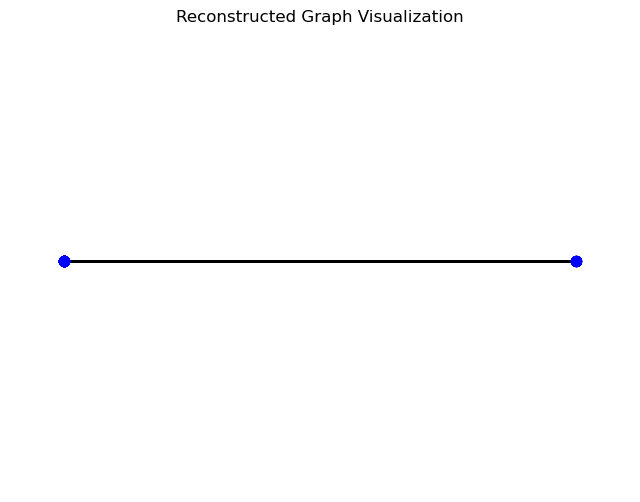

In [122]:

def visualize_graph(nodes, adj, threshold=0.1):
    """
    Visualize the graph with nodes and edges.
    
    Args:
        nodes (torch.Tensor): Node features, shape [num_nodes, node_dim]. We use first two dimensions as coordinates.
        adj (torch.Tensor): Adjacency matrix, shape [num_nodes, num_nodes].
        threshold (float): Only display edges with probability above threshold.
    """
    nodes = nodes.cpu().detach().numpy()
    adj = adj.cpu().detach().numpy()
    
    print("node",nodes)
    print("edges",adj)
    
    # Create a NetworkX graph
    G = nx.Graph()
    num_nodes = nodes.shape[0]
    
    # Use the first two dimensions of each node as (x, y) coordinates.
    pos = {i: (nodes[i, 0], nodes[i, 1]) for i in range(num_nodes)}
    
    # Add nodes
    for i in range(num_nodes):
        G.add_node(i)
    
    # Add edges based on threshold
    for i in range(num_nodes):
        for j in range(i+1, num_nodes):
            if adj[i, j] > threshold:
                G.add_edge(i, j, weight=adj[i, j])
    
    # Plot the graph
    plt.figure(figsize=(8, 6))
    nx.draw_networkx_nodes(G, pos, node_size=50, node_color='blue')
    nx.draw_networkx_edges(G, pos, alpha=0.5)
    plt.title("Reconstructed Graph Visualization")
    plt.axis('off')
    plt.show()
    
    
visualize_graph(reconstructed_nodes, reconstructed_adj, threshold=0.1)


Number of nodes: 1021
Number of edges: 0


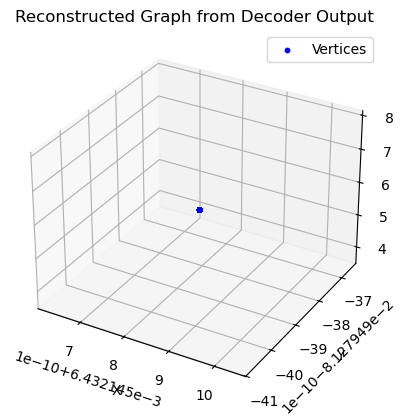

In [123]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Needed for 3D plotting
import networkx as nx
import torch

def visualize_3d(vertices, edges, title="3D Graph Visualization"):
    """
    Visualize a 3D graph given vertices and edges.

    :param vertices: numpy array of shape (n, 3) representing the 3D coordinates of the vertices.
    :param edges: numpy array of shape (2, m) where each column represents an edge (start_index, end_index).
    :param title: Title for the plot.
    """
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Plot vertices
    ax.scatter(vertices[:, 0], vertices[:, 1], vertices[:, 2],
               c='b', marker='o', s=10, label="Vertices")

    # Plot edges
    for i in range(edges.shape[1]):
        v1, v2 = edges[:, i]
        ax.plot([vertices[v1, 0], vertices[v2, 0]],
                [vertices[v1, 1], vertices[v2, 1]],
                [vertices[v1, 2], vertices[v2, 2]],
                c='r', linewidth=1)

    ax.set_title(title)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    
    # Equal scaling for all axes:
    max_range = np.array([vertices[:, 0].max() - vertices[:, 0].min(),
                          vertices[:, 1].max() - vertices[:, 1].min(),
                          vertices[:, 2].max() - vertices[:, 2].min()]).max() / 2.0
    mid_x = (vertices[:, 0].max() + vertices[:, 0].min()) * 0.5
    mid_y = (vertices[:, 1].max() + vertices[:, 1].min()) * 0.5
    mid_z = (vertices[:, 2].max() + vertices[:, 2].min()) * 0.5
    ax.set_xlim(mid_x - max_range, mid_x + max_range)
    ax.set_ylim(mid_y - max_range, mid_y + max_range)
    ax.set_zlim(mid_z - max_range, mid_z + max_range)
    
    plt.legend()
    plt.show()

def visualize_decoder_output(reconstructed_nodes, reconstructed_adj, edge_threshold=0.5):
    """
    Visualize the output of the decoder by converting the reconstructed adjacency matrix
    to a binary edge list based on a threshold, and using the first 3 dimensions of 
    reconstructed_nodes as the (x, y, z) coordinates.

    :param reconstructed_nodes: Tensor of shape [num_nodes, node_dim]. (Use first 3 dims as coordinates.)
    :param reconstructed_adj: Tensor of shape [num_nodes, num_nodes] with edge probabilities.
    :param edge_threshold: Threshold to decide if an edge exists.
    """
    # Convert tensors to numpy arrays
    nodes_np = reconstructed_nodes[:, :3].cpu().detach().numpy()  # Use only the first 3 dimensions as coordinates
    adj_np = reconstructed_adj.cpu().detach().numpy()
    
    # Threshold the adjacency to create a binary edge mask
    binary_adj = (adj_np > edge_threshold).astype(int)
    
    # Extract edge indices from the binary adjacency matrix
    # We only need each edge once (undirected graph): use np.where on upper triangle.
    i_indices, j_indices = np.where(np.triu(binary_adj, k=1))
    edges_np = np.stack([i_indices, j_indices], axis=0)  # Shape: [2, num_edges]
    
    print("Number of nodes:", nodes_np.shape[0])
    print("Number of edges:", edges_np.shape[1])
    visualize_3d(nodes_np, edges_np, title="Reconstructed Graph from Decoder Output")

# Example usage in your inference/training loop:
# Assume that your training step yields:
# reconstructed_nodes, reconstructed_adj = model['graph_decoder'](z_qG, graph_x.size(0))
#
# Then call the visualization function:
visualize_decoder_output(reconstructed_nodes, reconstructed_adj, edge_threshold=0.5)


In [124]:
print("Number of nodes:", reconstructed_nodes.size(0))
print("Adjacency stats:", reconstructed_adj.min().item(), reconstructed_adj.max().item(), reconstructed_adj.mean().item())
print("node stats:", reconstructed_nodes.min().item(), reconstructed_nodes.max().item(), reconstructed_nodes.mean().item())


Number of nodes: 1021
Adjacency stats: 0.10380306094884872 0.10380306094884872 0.10380304604768753
node stats: -0.08127949386835098 0.0504627525806427 -0.008128197863698006


In [125]:
class AutoMeshWrapper(nn.Module):
    def __init__(self, text_encoder, graph_encoder, feature_fusion, vector_quantizer, graph_decoder):
        super(AutoMeshWrapper, self).__init__()
        self.text_encoder = text_encoder
        self.graph_encoder = graph_encoder
        self.feature_fusion = feature_fusion
        self.vector_quantizer = vector_quantizer
        self.graph_decoder = graph_decoder

    def forward(self, text_input, graph_x, edge_index, num_nodes):
        # text_input: [batch_size, seq_len, embed_dim]
        # graph_x: [num_nodes, feature_dim]
        # edge_index: [2, num_edges]
        c_text = self.text_encoder(text_input)
        z_G = self.graph_encoder(graph_x, edge_index)
        fused_features = self.feature_fusion(c_text, z_G)
        z_qG, _ = self.vector_quantizer(fused_features)
        reconstructed_nodes, reconstructed_adj = self.graph_decoder(z_qG, num_nodes)
        return reconstructed_nodes, reconstructed_adj


In [127]:
# Re-instantiate your modules, load the state dicts
# ...
# Then wrap them:
wrapper = AutoMeshWrapper(
    model["text_encoder"],
    model["graph_encoder"],
    model["feature_fusion"],
    model["vector_quantizer"],
    model["graph_decoder"]
).eval()

# TorchScript conversion (scripting or tracing)
scripted_model = torch.jit.script(wrapper)
scripted_model.save("automesh_scripted.pt")


NotSupportedError: keyword-arg expansion is not supported:
  File "d:\SURAJ\anaconda3\Lib\site-packages\torch\nn\modules\normalization.py", line 206
    def extra_repr(self) -> str:
        return '{normalized_shape}, eps={eps}, ' \
            'elementwise_affine={elementwise_affine}'.format(**self.__dict__)
                                                               ~~~~~~~~~~~~~ <--- HERE
